Train MSE: 26.43
Drifted Data MSE: 27.33
KS test statistic: 0.610, p-value: 0.000
Significant distribution difference detected (possible data drift)


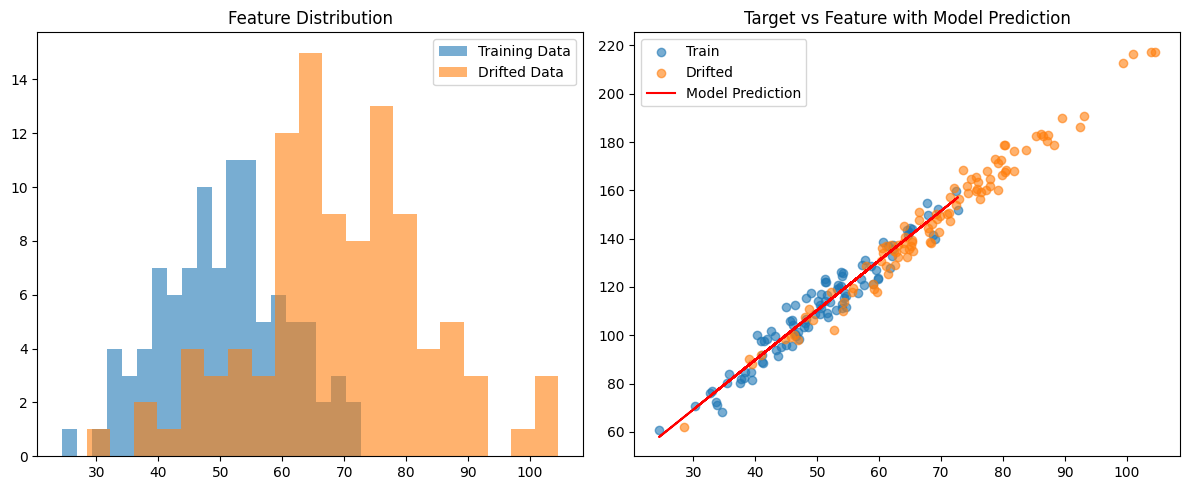

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import ks_2samp

# ---- Part 1: Create original training data---
np.random.seed(0)
n_samples = 100
X_train = np.random.normal(loc=50, scale=10, size=(n_samples, 1))
noise_train = np.random.normal(0, 5, size=(n_samples,))
y_train = 2 * X_train.flatten() + 10 + noise_train
df_train = pd.DataFrame({"feature": X_train.flatten(), "target": y_train})

# ---- Part 2: Create new (drifted) data ----
# Introduce data drift by changing mean and variance of feature
X_drift = np.random.normal(loc=70, scale=15, size=(n_samples, 1))  # shifted mean + higher variance
noise_drift = np.random.normal(0, 5, size=(n_samples,))
y_drift = 2 * X_drift.flatten() + 10 + noise_drift
df_drift = pd.DataFrame({"feature": X_drift.flatten(), "target": y_drift})

# ---- Task 1: Train model on original data ----
model = LinearRegression()
model.fit(df_train[["feature"]], df_train["target"])

# Predict on both datasets
y_train_pred = model.predict(df_train[["feature"]])
y_drift_pred = model.predict(df_drift[["feature"]])

# Compute errors
train_mse = mean_squared_error(df_train["target"], y_train_pred)
drift_mse = mean_squared_error(df_drift["target"], y_drift_pred)

print(f"Train MSE: {train_mse:.2f}")
print(f"Drifted Data MSE: {drift_mse:.2f}")

# ---- Task 2: Monitoring Distribution Changes with KS test ----
stat, p_value = ks_2samp(df_train["feature"], df_drift["feature"])
print(f"KS test statistic: {stat:.3f}, p-value: {p_value:.3f}")
if p_value < 0.05:
    print("Significant distribution difference detected (possible data drift)")
else:
    print("No significant distribution difference detected")

# ---- Task 3: Visualizing Data Drift ----
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_train["feature"], bins=20, alpha=0.6, label="Training Data")
plt.hist(df_drift["feature"], bins=20, alpha=0.6, label="Drifted Data")
plt.title("Feature Distribution")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(df_train["feature"], df_train["target"], alpha=0.6, label="Train")
plt.scatter(df_drift["feature"], df_drift["target"], alpha=0.6, label="Drifted")
plt.plot(df_train["feature"], y_train_pred, color="red", label="Model Prediction")
plt.title("Target vs Feature with Model Prediction")
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
!pip install great_expectations

import pandas as pd
import great_expectations as ge
from great_expectations.core.batch import BatchRequest
from great_expectations.data_context import DataContext
from great_expectations.datasource.fluent import PandasDatasource

# Sample data with a null in 'age'
data = {
    "id": [1, 2, 3, 4, 5],
    "age": [25, 35, 45, 55, None],  # One null value
    "income": [50000, 60000, 70000, 80000, 90000]
}
df = pd.DataFrame(data)

# Create a minimal in-memory DataContext (Ephemeral context)
context = DataContext.create(project_root_dir=None)

# Add a PandasDatasource (FluentDatasource)
if "my_pandas" not in [ds["name"] for ds in context.list_datasources()]:
    context.add_datasource(
        name="my_pandas",
        datasource=PandasDatasource(name="my_pandas"),
    )

# Create a BatchRequest to pass the DataFrame as runtime data
batch_request = BatchRequest(
    datasource_name="my_pandas",
    data_connector_name="default_runtime_data_connector",
    data_asset_name="default_data_asset_name",
    runtime_parameters={"batch_data": df},
    batch_identifiers={"default_identifier_name": "default_id"},
)

# Create or load an expectation suite
expectation_suite_name = "test_suite"
try:
    suite = context.get_expectation_suite(expectation_suite_name)
except Exception:
    suite = context.create_expectation_suite(expectation_suite_name)

# Create Validator to validate batch data
validator = context.get_validator(
    batch_request=batch_request,
    expectation_suite_name=expectation_suite_name,
)

# Add expectations
validator.expect_column_values_to_not_be_null("age")
validator.expect_column_values_to_be_between("age", min_value=18, max_value=65)
validator.expect_column_values_to_be_unique("id")

# Run validation and print results
results = validator.validate()
print(results)

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


ImportError: cannot import name 'DataContext' from 'great_expectations.data_context' (/home/vscode/.local/lib/python3.10/site-packages/great_expectations/data_context/__init__.py)

In [ ]:
!pip install great_expectations

import pandas as pd
from great_expectations.data_context import FileDataContext
from great_expectations.core.batch import BatchRequest
from great_expectations.datasource.fluent import PandasDatasource

# Create sample data
data = {
    "id": [1, 2, 3, 4, 5],
    "age": [25, 35, 45, 55, None],  # null value to test expectation failure
    "income": [50000, 60000, 70000, 80000, 90000],
}
df = pd.DataFrame(data)

# Use EphemeralDataContext for in-memory operation (no files needed)
from great_expectations.data_context import EphemeralDataContext

context = EphemeralDataContext()

# Add a Pandas datasource if not already present
if "my_pandas" not in [ds["name"] for ds in context.list_datasources()]:
    context.add_datasource(
        name="my_pandas",
        datasource=PandasDatasource(name="my_pandas"),
    )

# Create a BatchRequest with the runtime pandas dataframe
batch_request = BatchRequest(
    datasource_name="my_pandas",
    data_connector_name="default_runtime_data_connector",
    data_asset_name="default_data_asset_name",
    runtime_parameters={"batch_data": df},
    batch_identifiers={"default_identifier_name": "default_id"},
)

# Create or get expectation suite
expectation_suite_name = "test_suite"
try:
    suite = context.get_expectation_suite(expectation_suite_name)
except Exception:
    suite = context.create_expectation_suite(expectation_suite_name)

# Create validator with batch data and suite
validator = context.get_validator(
    batch_request=batch_request,
    expectation_suite_name=expectation_suite_name,
)

# Add expectations
validator.expect_column_values_to_not_be_null("age")
validator.expect_column_values_to_be_between("age", min_value=18, max_value=65)
validator.expect_column_values_to_be_unique("id")

# Validate and print results
results = validator.validate()
print(results)

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


TypeError: EphemeralDataContext.__init__() missing 1 required positional argument: 'project_config'

In [ ]:
import pandas as pd
from great_expectations.data_context import EphemeralDataContext
from great_expectations.datasource.fluent import PandasDatasource
from great_expectations.core.batch import BatchRequest

# Sample data
data = {
    "id": [1, 2, 3, 4, 5],
    "age": [25, 35, 45, 55, None],  # has a null to check validation
    "income": [50000, 60000, 70000, 80000, 90000],
}
df = pd.DataFrame(data)

# Minimal project_config for EphemeralDataContext
project_config = {
    "datasources": {},
    "expectations_store_name": "expectations_store",
    "validations_store_name": "validations_store",
    "stores": {
        "expectations_store": {
            "class_name": "InMemoryStore"
        },
        "validations_store": {
            "class_name": "InMemoryStore"
        }
    },
    "data_docs_sites": {},
    "anonymous_usage_statistics": {
        "enabled": False
    }
}

# Create EphemeralDataContext with the minimal config
context = EphemeralDataContext(project_config=project_config)

# Add Pandas datasource
if "my_pandas" not in [ds["name"] for ds in context.list_datasources()]:
    context.add_datasource(
        name="my_pandas",
        datasource=PandasDatasource(name="my_pandas")
    )

# Create BatchRequest for runtime pandas DataFrame
batch_request = BatchRequest(
    datasource_name="my_pandas",
    data_connector_name="default_runtime_data_connector",
    data_asset_name="default_data_asset_name",
    runtime_parameters={"batch_data": df},
    batch_identifiers={"default_identifier_name": "default_id"},
)

# Create or load expectation suite
expectation_suite_name = "test_suite"
try:
    context.get_expectation_suite(expectation_suite_name)
except Exception:
    context.create_expectation_suite(expectation_suite_name)

# Get validator
validator = context.get_validator(
    batch_request=batch_request,
    expectation_suite_name=expectation_suite_name,
)

# Add some expectations
validator.expect_column_values_to_not_be_null("age")
validator.expect_column_values_to_be_between("age", min_value=18, max_value=65)
validator.expect_column_values_to_be_unique("id")

# Run validation and print results
results = validator.validate()
print(results)

Error while processing DataContextConfig: no config_version key


InvalidDataContextConfigError: Error while processing DataContextConfig: no config_version key

In [ ]:
!pip install great_expectations pandas
!python your_script.py

import pandas as pd
from great_expectations.data_context import EphemeralDataContext
from great_expectations.datasource.fluent import PandasDatasource
from great_expectations.core.batch import BatchRequest

# Sample data
data = {
    "id": [1, 2, 3, 4, 5],
    "age": [25, 35, 45, 55, None],
    "income": [50000, 60000, 70000, 80000, 90000],
}
df = pd.DataFrame(data)

# Minimal project_config with config_version key
project_config = {
    "config_version": 3,  # must be present and correct version
    "datasources": {},
    "expectations_store_name": "expectations_store",
    "validations_store_name": "validations_store",
    "stores": {
        "expectations_store": {
            "class_name": "InMemoryStore"
        },
        "validations_store": {
            "class_name": "InMemoryStore"
        }
    },
    "data_docs_sites": {},
    "anonymous_usage_statistics": {
        "enabled": False
    }
}

# Create EphemeralDataContext with the minimal config
context = EphemeralDataContext(project_config=project_config)

# Add Pandas datasource if not exists
if "my_pandas" not in [ds["name"] for ds in context.list_datasources()]:
    context.add_datasource(
        name="my_pandas",
        datasource=PandasDatasource(name="my_pandas")
    )

# Create BatchRequest for runtime pandas DataFrame
batch_request = BatchRequest(
    datasource_name="my_pandas",
    data_connector_name="default_runtime_data_connector",
    data_asset_name="default_data_asset_name",
    runtime_parameters={"batch_data": df},
    batch_identifiers={"default_identifier_name": "default_id"},
)

# Create or load expectation suite
expectation_suite_name = "test_suite"
try:
    context.get_expectation_suite(expectation_suite_name)
except Exception:
    context.create_expectation_suite(expectation_suite_name)

# Get validator
validator = context.get_validator(
    batch_request=batch_request,
    expectation_suite_name=expectation_suite_name,
)

# Add some expectations
validator.expect_column_values_to_not_be_null("age")
validator.expect_column_values_to_be_between("age", min_value=18, max_value=65)
validator.expect_column_values_to_be_unique("id")

# Run validation and print results
results = validator.validate()
print(results)

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
python: can't open file '/workspaces/AI_DATA_ANALYSIS_/src/Module 4/Advanced Data Quality & Validation/your_script.py': [Errno 2] No such file or directory


Error The module: `great_expectations.data_context.store` does not contain the class: `InMemoryStore`.
        - Please verify that the class named `InMemoryStore` exists. occurred while attempting to instantiate a store.


ClassInstantiationError: The module "great_expectations.data_context.store" exists; however, the system is unable to create an instance of the class "InMemoryStore", searched for inside this module.  Please make sure that the class named "InMemoryStore" is properly defined inside its intended module and declared correctly by the calling entity.  This error is unrecoverable.
            